In [3]:
##import necessary modules
import matplotlib.pyplot as plt
import earthpy.spatial as es
import earthpy.plot as ep
import numpy as np
import scipy
import random
import math 
from osgeo import gdal, gdalconst
from rasterio.plot import show
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import shannon_entropy
from skimage.color import rgb2gray
from skimage.morphology import reconstruction
from skimage.morphology import erosion
from skimage.morphology import disk
from skimage import util
from numpy import load
from numpy import asarray
from numpy import save
from numpy import savetxt
from numpy import loadtxt
import scipy.io as sp

In [4]:
##define input imagery
#full imagery
asi = 'Imagery/SatelliteImagery/SingleDateImage_Amsterdam.tif'
ami = 'Imagery/SatelliteImagery/MedianImage_Amsterdam.tif'
msi = 'Imagery/SatelliteImagery/SingleDateImage_Milano.tif'
mmi = 'Imagery/SatelliteImagery/MedianImage_Milano.tif'
bsi = 'Imagery/SatelliteImagery/SingleDateImage_Budapest.tif'
bmi = 'Imagery/SatelliteImagery/MedianImage_Budapest.tif'
filist = [asi, ami, msi, mmi, bsi, bmi]
#Subsets
asisub = 'Imagery/SatelliteImagery/Subset_SingleDateImage_Amsterdam.tif'
amisub = 'Imagery/SatelliteImagery/Subset_MedianImage_Amsterdam.tif'
msisub = 'Imagery/SatelliteImagery/Subset_SingleDateImage_Milano.tif'
mmisub = 'Imagery/SatelliteImagery/Subset_MedianImage_Milano.tif'
bsisub = 'Imagery/SatelliteImagery/Subset_SingleDateImage_Budapest.tif'
bmisub = 'Imagery/SatelliteImagery/Subset_MedianImage_Budapest.tif'
sublist = [asisub, amisub, msisub, mmisub, bsisub, bmisub]
sublisttest = [asisub]
##Images with extracted features
empasi = load('Output/empasi.npy')
glcmasi = load('Output/glcmasi.npy')
empmsi = load('Output/empmsi.npy')
glcmmsi = load('Output/glcmmsi.npy')
empbsi = load('Output/empbsi.npy')
glcmbsi = load('Output/glcmbsi.npy')
##Twitter
atwitter = 'Imagery/TwitterRaster/TwitterRaster_Amsterdam.tif'
mtwitter = 'Imagery/TwitterRaster/Budapest_Twitter_Raster.tif'
btwitter = 'Imagery/TwitterRaster/Milano_Twitter_Raster.tif'
atwittersub = 'Imagery/TwitterRaster/Subset_TwitterRaster_Amsterdam.tif' 
mtwittersub = 'Imagery/TwitterRaster/Subset_TwitterRaster_Milano.tif'
btwittersub = 'Imagery/TwitterRaster/Subset_TwitterRaster_Budapest.tif'
##validation datasets
avalsub = 'Imagery/ValidationRaster/Subset_Validation_30m_Amsterdam.tif'
mvalsub = 'Imagery/ValidationRaster/Subset_Validation_30m_Milano.tif'
bvalsub = 'Imagery/ValidationRaster/Subset_Validation_30m_Budapest.tif'

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn.preprocessing import MinMaxScaler

In [6]:
def read_data_EMP(inras):
    # Read data
    img = gdal.Open(inras, gdal.GA_ReadOnly) 
    bands = [img.GetRasterBand(i).ReadAsArray() for i in range(1, img.RasterCount + 1)]
    img = np.array(bands) # numpy array [band, row, col]
    img = img[0:12,:,:] # 12 spectral bands
    img = np.transpose(img, [1, 2, 0]) # numpy array [row, col, bands]
    #img = img[np.logical_not(np.isnan(img))]
    #print(img.shape)
    # B2-->Blue
    # B3-->Green
    # B4-->Red
    # remember the indexes in NumPy arrays start with 0 --> bands begin from 0!
    img_rgb = img[:,:,[3,2,1]]
    return img

img = read_data_EMP(asisub)

In [7]:
#PCA
#nr,nc,nb = img.shape #all bands
#X = img.reshape((nr*nc, nb))
# nr,nc,nb = img[:,:,[1,2,3,7]].shape # 10m bands
# X = img[:,:,[1,2,3,7]].reshape((nr*nc, nb))
##X.shape
#X_std = StandardScaler().fit_transform(X)
#pca = decomposition.PCA(n_components=3)
#pca.fit(X_std)
#X_pca = pca.transform(X_std)
##X_pca.shape
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaler.fit(X_pca)
#img_pca = X_pca.reshape((nr,nc,3))
#print(img_pca.shape)
#Pseudocolor image extracted through PCA analysis
#plt.imshow(MyNormalize(img_pca,1))
#print(img_pca)

In [8]:
#GLCM
def read_data_GLCM(inraster):
    def convert(img_g, target_type_min, target_type_max, target_type):
        imin = np.amin(img_g)
        imax = np.amax(img_g)
        a = (target_type_max - target_type_min) / (imax - imin)
        b = target_type_max - a * imax
        new_img = (a * img_g + b).astype(target_type)
        return new_img
    
    img = gdal.Open(inraster, gdal.GA_ReadOnly) 
    bands = [img.GetRasterBand(i).ReadAsArray() for i in range(1, img.RasterCount + 1)]
    img = np.array(bands)
    img = img[0:12,:,:]
    img = np.transpose(img, [1, 2, 0])
    imgblue = img[:,:,[1]]
    imgblue = imgblue[:, :, 0]
    imggreen = img[:,:,[2]]
    imggreen = imggreen[:, :, 0]
    imgred = img[:,:,[3]]
    imgred = imgred[:, :, 0]
    imgnir = img[:,:,[7]]
    imgnir = imgnir[:, :, 0]
    img_rgb = img[:,:,[3,2,1]]
    blueband = convert(imgblue, 0, 256, np.uint8)
    greenband = convert(imggreen, 0, 256, np.uint8)
    redband = convert(imgred, 0, 256, np.uint8)
    nirband = convert(imgnir, 0, 256, np.uint8)
    return blueband, greenband, redband, nirband

def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value 

def MyNormalize(img_i,sigma):
    nr,nc,nb = img_i.shape
    img_n = np.zeros(shape=(nr,nc,nb))
    for i in range(0,nb):
        one_band = img_i[:,:,i]
        mi = np.min(one_band)
        ma = np.max(one_band)
        one_band = (one_band-mi)/(ma-mi+np.finfo(float).eps)
        img_n[:,:,i] = sigma*one_band
    return img_n

def glcm(inputraster, window):
    def createemptyraster(inputraster, padding):
        def pad_with(vector, pad_width, iaxis, kwargs):
            pad_value = kwargs.get('padder', 0)
            vector[:pad_width[0]] = pad_value
            vector[-pad_width[1]:] = pad_value  
                #define empty contrast
        inarray1 = inputraster
        emptyraster1 = np.pad(inarray1, padding, pad_with) 
        emptyraster1[:] = 0
        emptyraster1 = emptyraster1.astype(float)
            #define empty correlation
        inarray2 = inputraster
        emptyraster2 = np.pad(inarray2, padding, pad_with) 
        emptyraster2[:] = 0
        emptyraster2 = emptyraster2.astype(float)
            #define empty homogeneity
        inarray3 = inputraster
        emptyraster3 = np.pad(inarray3, padding, pad_with) 
        emptyraster3[:] = 0
        emptyraster3 = emptyraster3.astype(float)
            #define empty dissimilarity
        inarray4 = inputraster
        emptyraster4 = np.pad(inarray4, padding, pad_with) 
        emptyraster4[:] = 0
        emptyraster4 = emptyraster4.astype(float)
        return emptyraster1, emptyraster2, emptyraster3, emptyraster4
    
    def glcmd1(inputraster, originalraster, emptyraster, direction, glcmprop, padding, windowsize):
        inraster = inputraster
        a = windowsize[0]
        b = windowsize[1]
        for i in range(inraster.shape[0]):
            for j in range(inraster.shape[1]):
                #windows needs to fit completely in image
                if i <(padding+2) or j < (padding+2):
                    continue
                if i > (inraster.shape[0] - (padding+2)) or j > (inraster.shape[0] - (padding+2)):
                    continue
                    #Calculate GLCM on a 7x7 window
                glcm_window = originalraster[i-windowsize[0]: i+windowsize[1], j-windowsize[0]:j+windowsize[1]]
                glcm = graycomatrix(glcm_window, [1], [direction])
                #Calculate contrast and replace center pixel
                prop = graycoprops(glcm, glcmprop)
                emptyraster[i,j] = prop
                propglcmd1 = emptyraster[padding:-padding, padding:-padding]
        return propglcmd1

    def glcmd2(inputraster, originalraster, emptyraster, direction, glcmprop, padding, windowsize):
        inraster = inputraster
        for i in range(inraster.shape[0] ):
            for j in range(inraster.shape[1] ):
                #windows needs to fit completely in image
                if i <(padding+2) or j < (padding+2):
                    continue
                if i > (inraster.shape[0] - (padding+2)) or j > (inraster.shape[0] - (padding+2)):
                    continue
                    #Calculate GLCM on a 7x7 window
                glcm_window = originalraster[i-windowsize[0]: i+windowsize[1], j-windowsize[0]:j+windowsize[1]]
                glcm = graycomatrix(glcm_window, [1], [direction])
                    #Calculate contrast and replace center pixel
                prop = graycoprops(glcm, glcmprop)
                emptyraster[i,j] = prop
                propglcmd2 = emptyraster[padding:-padding, padding:-padding]
        return propglcmd2

    def glcmd3(inputraster, originalraster, emptyraster, direction, glcmprop, padding, windowsize):
        inraster = inputraster
        for i in range(inraster.shape[0] ):
            for j in range(inraster.shape[1] ):
                #windows needs to fit completely in image
                if i <(padding+2) or j < (padding+2):
                    continue
                if i > (inraster.shape[0] - (padding+2)) or j > (inraster.shape[0] - (padding+2)):
                    continue
                    #Calculate GLCM on a 7x7 window
                glcm_window = originalraster[i-windowsize[0]: i+windowsize[1], j-windowsize[0]:j+windowsize[1]]
                glcm = graycomatrix(glcm_window, [1], [direction])
                    #Calculate contrast and replace center pixel
                prop = graycoprops(glcm, glcmprop)
                emptyraster[i,j] = prop
                propglcmd3 = emptyraster[padding:-padding, padding:-padding]
        return propglcmd3

    def glcmd4(inputraster, originalraster, emptyraster, direction, glcmprop, padding, windowsize):
        inraster = inputraster
        for i in range(inraster.shape[0] ):
            for j in range(inraster.shape[1] ):
                #windows needs to fit completely in image
                if i <(padding+2) or j < (padding+2):
                    continue
                if i > (inraster.shape[0] - (padding+2)) or j > (inraster.shape[0] - (padding+2)):
                    continue
                    #Calculate GLCM on a 7x7 window
                glcm_window = originalraster[i-windowsize[0]: i+windowsize[1], j-windowsize[0]:j+windowsize[1]]
                glcm = graycomatrix(glcm_window, [1], [direction])
                    #Calculate contrast and replace center pixel
                prop = graycoprops(glcm, glcmprop)
                emptyraster[i,j] = prop
                propglcmd4 = emptyraster[padding:-padding, padding:-padding]
        return propglcmd4
    
    def glcm_mean(inputraster, originalraster, emptyraster, padding, windowsize):
        inraster = inputraster
        for i in range(inraster.shape[0]):
            for j in range(inraster.shape[1]):
                #windows needs to fit completely in image
                if i <(padding+2) or j < (padding+2):
                    continue
                if i > (inraster.shape[0] - (padding+2)) or j > (inraster.shape[0] - (padding+2)):
                    continue
                    #Calculate GLCM on a 7x7 window
                glcm_window = originalraster[i-windowsize[0]: i+windowsize[1], j-windowsize[0]:j+windowsize[1]]
                mean = np.mean(glcm_window)
                emptyraster[i,j] = mean
                glcmmean = emptyraster[padding:-padding, padding:-padding]
        return glcmmean
                
    def glcmvar(inputraster, originalraster, emptyraster, direction, padding, windowsize):
        inraster = inputraster
        for i in range(inraster.shape[0] ):
            for j in range(inraster.shape[1] ):
                #windows needs to fit completely in image
                if i <(padding+2) or j < (padding+2):
                    continue
                if i > (inraster.shape[0] - (padding+2)) or j > (inraster.shape[0] - (padding+2)):
                    continue
                    #Calculate GLCM on a 7x7 window
                glcm_window = originalraster[i-windowsize[0]: i+windowsize[1], j-windowsize[0]:j+windowsize[1]]
                glcm = graycomatrix(glcm_window, [1], [direction])
                    #Calculate contrast and replace center pixel
                variance = np.var(glcm)
                emptyraster[i,j] = variance
                glcmvariance = emptyraster[padding:-padding, padding:-padding]
        return glcmvariance

    #def glcmentropy(inputraster, originalraster, emptyraster, direction):
    #    inraster = inputraster
    #    for i in range(inraster.shape[0] ):
    #        for j in range(inraster.shape[1] ):
    #            #windows needs to fit completely in image
    #            if i <3 or j <3:
    #                continue
    #            if i > (inraster.shape[0] - 4) or j > (inraster.shape[0] - 4):
    #                continue
    #                #Calculate GLCM on a 7x7 window
    #            glcm_window = originalraster[i-3: i+3, j-3 : j+3]
    #            glcm = graycomatrix(glcm_window, [1], [direction])
    #                #Calculate contrast and replace center pixel
    #            entropy = shannon_entropy(glcm)
    #            emptyraster[i,j] = entropy
    #            glcmentropy = emptyraster[3:-3, 3:-3]
    #    return glcmentropy
    
    #windowsizes 1=7x7, 2=9x9, 3 =11x11, 4=13x13, 5=15x15, 6=17x17, 7=19x19
    windowsizes = {1:[3,4], 2:[4,5], 3:[5,6], 4:[6,7], 5:[7,8], 6:[8,9], 7:[9,10]}
    windowsize = windowsizes[window]
    padding = windowsize[1]
    directions = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcmprop = ['contrast', 'correlation', 'homogeneity', 'dissimilarity', 'ASM']
    originalraster = inputraster
    a, b, c, d = createemptyraster(inputraster, padding)
    inraster = np.pad(originalraster, padding, pad_with)
    
    # calculate mean of 4 directions GLCM
    contrastd1 = glcmd1(inraster, originalraster, a, directions[0], glcmprop[0], padding, windowsize)
    contrastd2 = glcmd2(inraster, originalraster, b, directions[1], glcmprop[0], padding, windowsize)
    contrastd3 = glcmd3(inraster, originalraster, c, directions[2], glcmprop[0], padding, windowsize)
    contrastd4 = glcmd4(inraster, originalraster, d, directions[3], glcmprop[0], padding, windowsize)
    contrastmin = np.amin([contrastd1,contrastd2,contrastd3,contrastd4], axis=0)
    
    dissimilarityd1 = glcmd1(inraster, originalraster, a, directions[0], glcmprop[3], padding, windowsize)
    dissimilarityd2 = glcmd2(inraster, originalraster, b, directions[1], glcmprop[3], padding, windowsize)
    dissimilarityd3 = glcmd3(inraster, originalraster, c, directions[2], glcmprop[3], padding, windowsize)
    dissimilarityd4 = glcmd4(inraster, originalraster, d, directions[3], glcmprop[3], padding, windowsize)
    dissimilaritymin = np.amin([dissimilarityd1,dissimilarityd2,dissimilarityd3,dissimilarityd4], axis=0)
    
    varianced1 = glcmvar(inraster, originalraster, a, directions[0], padding, windowsize)
    varianced2 = glcmvar(inraster, originalraster, b, directions[1], padding, windowsize)
    varianced3 = glcmvar(inraster, originalraster, c, directions[2], padding, windowsize)
    varianced4 = glcmvar(inraster, originalraster, d, directions[3], padding, windowsize)
    variancemin = np.amin([varianced1,varianced2,varianced3,varianced4], axis=0)
    
    mean = glcm_mean(inraster, originalraster, a, padding, windowsize)
       
    #correlationd1 = glcmd1(inraster, originalraster, a, directions[0], glcmprop[1])
    #correlationd2 = glcmd2(inraster, originalraster, b, directions[1], glcmprop[1])
    #correlationd3 = glcmd3(inraster, originalraster, c, directions[2], glcmprop[1])
    #correlationd4 = glcmd4(inraster, originalraster, d, directions[3], glcmprop[1])
    #correlationmean = np.amin([correlationd1,correlationd2,correlationd3,correlationd4], axis=0)
    
    #homogeneityd1 = glcmd1(inraster, originalraster, a, directions[0], glcmprop[2])
    #homogeneityd2 = glcmd2(inraster, originalraster, b, directions[1], glcmprop[2])
    #homogeneityd3 = glcmd3(inraster, originalraster, c, directions[2], glcmprop[2])
    #homogeneityd4 = glcmd4(inraster, originalraster, d, directions[3], glcmprop[2])
    #homogeneitymean = np.amin([homogeneityd1,homogeneityd2,homogeneityd3,homogeneityd4], axis=0)
     
    #ASMd1 = glcmd1(inraster, originalraster, a, directions[0], glcmprop[4])
    #ASMd2 = glcmd2(inraster, originalraster, b, directions[1], glcmprop[4])
    #ASMd3 = glcmd3(inraster, originalraster, c, directions[2], glcmprop[4])
    #ASMd4 = glcmd4(inraster, originalraster, d, directions[3], glcmprop[4])
    #ASMmean = np.amin([ASMd1,ASMd2,ASMd3,ASMd4], axis=0)
    
    #Entropyd1 = glcmentropy(inraster, originalraster, a, directions[0])
    #Entropyd2 = glcmentropy(inraster, originalraster, b, directions[1])
    #Entropyd3 = glcmentropy(inraster, originalraster, c, directions[2])
    #Entropyd4 = glcmentropy(inraster, originalraster, d, directions[3])
    #Entropymean = np.amin([Entropyd1,Entropyd2,Entropyd3,Entropyd4], axis=0)
    
    #stack all features in 1 3-d array
    #stacked = np.array([contrastmean, correlationmean, homogeneitymean, dissimilaritymean, 
    #                    ASMmean, Variancemean, Entropymean])
    stacked = np.array([contrastmin, dissimilaritymin, variancemin, mean])
    glcmoutput = np.transpose(stacked, [1, 2, 0])
    return glcmoutput

def visualizeglcm(glcmoutput):
    fig = plt.figure(figsize=(15, 15))
    rows = 4
    columns = 4
    #print("EMP:  "+str(glcmoutput.shape))  
    glcm_size = columns * rows
    for i in range(1, glcm_size+1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(glcmoutput[:, :, i-1], cmap='gray', interpolation='bicubic')
    
    plt.tight_layout()   
    return plt.show()

def constructglcm(inputraster, window):
    redband, greenband, blueband, nirband = read_data_GLCM(inputraster)
    bandlist = [redband, greenband, blueband, nirband]
    glcmdic = {}
    x = 0
    for i in bandlist:
        x += 1
        inras = i
        glcmdic[x] = glcm(inras, window)
    
    a = glcmdic[1] 
    b = glcmdic[2]
    c = glcmdic[3]
    d = glcmdic[4]
    GLCM = np.concatenate((a, b, c, d), axis=2)
    return GLCM

def constructPCAglcm(img_pca):
    pca1 = img_pca[:,:,0]
    pca2 = img_pca[:,:,1]
    pca3 = img_pca[:,:,2]
    pcalist = [pca1, pca2, pca3]
    pcaglcmdic = {}
    x = 0
    for i in pcalist:
        x += 1
        inras = i 
        pcaglcmdic[x] = glcm(inras)
    
    a = pcaglcmdic[1]
    b = pcaglcmdic[2]
    c = pcaglcmdic[3]
    GLCM = np.concatenate((a, b, c), axis = 2)
    return GLCM

In [8]:
%%time
#GLCM
#windowsizes 1=7x7, 2=9x9, 3=11x11, 4=13x13, 5=15x15, 6=17x17, 7=19x19

glcmdic = {}
x = 0 
for i in sublisttest: 
    x += 1
    inras = i 
    glcmdic[x] = constructglcm(inras, 4)

Wall time: 8min 23s


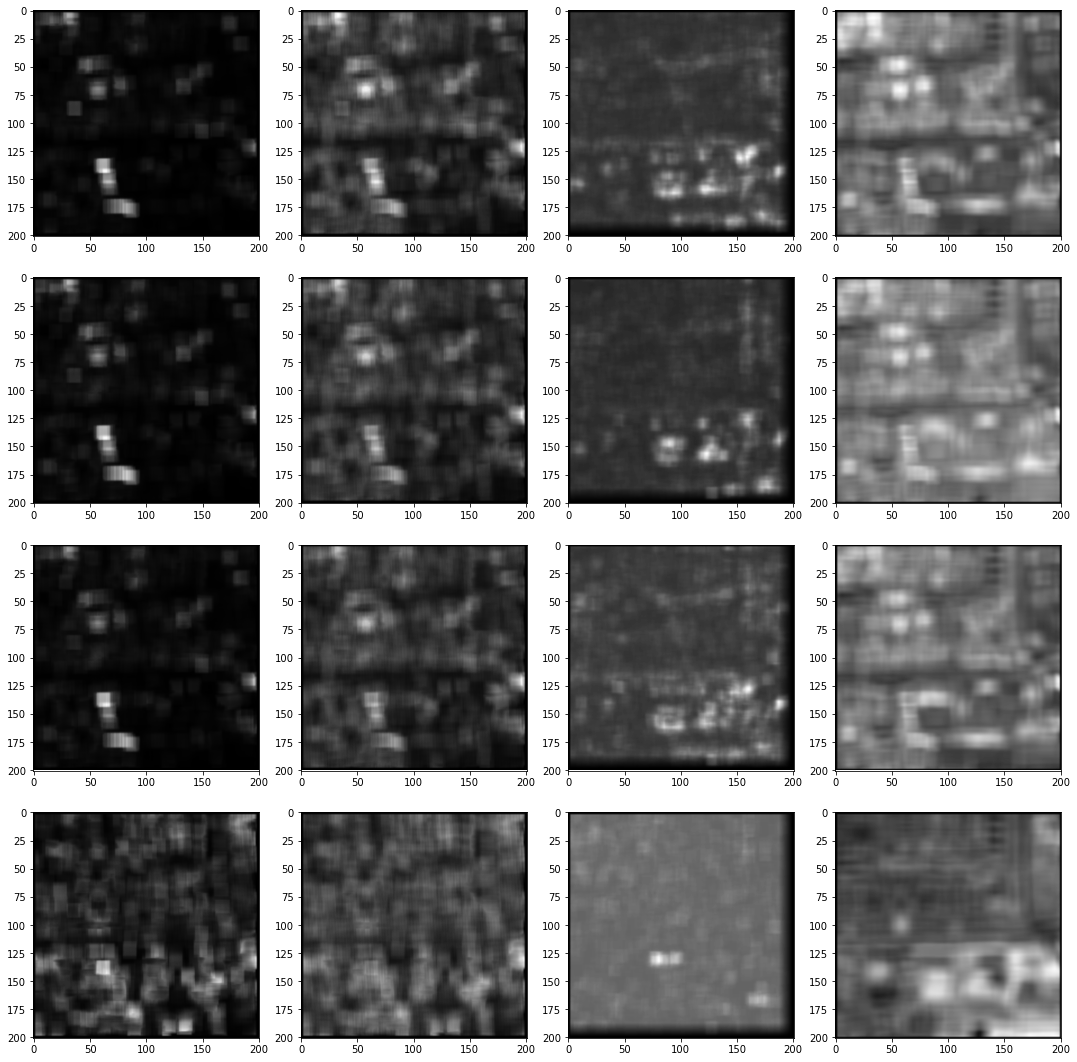

In [9]:
visualizeglcm(glcmdic[1])

In [10]:
# save arrays
save('Output/glcmasi.npy', glcmdic[1])
#save('Output/glcmami.npy', glcmdic[2])
#save('Output/glcmmsi.npy', glcmdic[3])
#save('Output/glcmmmi.npy', glcmdic[4])
#save('Output/glcmbsi.npy', glcmdic[5])
#save('Output/glcmbmi.npy', glcmdic[6])

In [11]:
# load arrays
glcmasi = load('Output/glcmasi.npy')
#glcmami = load('Output/glcmami.npy')
#glcmmsi = load('Output/glcmmsi.npy')
#glcmmmi = load('Output/glcmmmi.npy')
#glcmbsi = load('Output/glcmbsi.npy')
#glcmbmi = load('Output/glcmbmi.npy')

In [43]:
i_glcm_hom = sp.loadmat('Matlab/i_glcm_hom.mat')
for key in i_glcm_hom:
    print(key)
hom = i_glcm_hom['I_glcm_hom']
hom = np.ascontiguousarray(hom)
hom1 = hom[:,:,0]
hom2 = hom[:,:,1]

i_glcm_con = sp.loadmat('Matlab/i_glcm_con.mat')
for key in i_glcm_con:
    print(key)
con = i_glcm_con['I_glcm_con']
con = np.ascontiguousarray(con)
con1 = con[:,:,0]
con2 = con[:,:,1]

__header__
__version__
__globals__
I_glcm_hom
__header__
__version__
__globals__
I_glcm_con


In [44]:
print(hom.shape)

(201, 201, 2)


image: Imagery/SatelliteImagery/Subset_MedianImage_Milano.tif
Number of pervious pixels in image: 22635
Number of impervious pixels in image: 17766
Number of Twitter pixels in image: 51
Random sample of Twitter coordinates (row/col): [(22, 45), (64, 97), (22, 6), (78, 8), (103, 92), (2, 89), (12, 119), (25, 198), (185, 51), (97, 68), (77, 61), (11, 82), (32, 69), (31, 42), (19, 155), (34, 106), (91, 138), (64, 119), (12, 105), (44, 102), (25, 25), (35, 124), (23, 25), (77, 53), (177, 8), (80, 103), (83, 143), (27, 10), (35, 133), (111, 0), (20, 46), (111, 100), (61, 160), (123, 189), (37, 23), (116, 56), (22, 20), (99, 190), (122, 1), (32, 80), (17, 63), (30, 116), (98, 48), (16, 15), (23, 16), (24, 47), (90, 41), (13, 57), (76, 52), (65, 147)]
Random sample of Pervious coordinates (row/col): [(31, 76), (18, 127), (67, 77), (11, 73), (197, 0), (68, 146), (110, 85), (50, 160), (0, 50), (108, 101), (139, 20), (93, 113), (174, 54), (169, 48), (69, 28), (77, 82), (15, 130), (39, 7), (97, 1

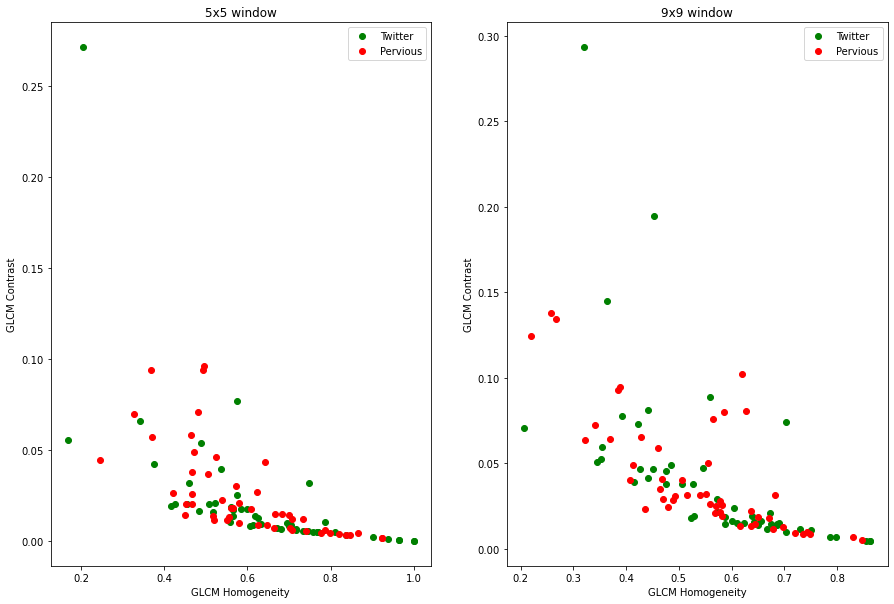

In [45]:
#Random pixel from witterraster
'''
call function:
image = read_twitter(inputraster)
plot = plt.imshow(image)
'''
def read_twitter(inras):
    twitter = gdal.Open(inras, gdal.GA_ReadOnly)
    band = twitter.GetRasterBand(1).ReadAsArray()
    twitter = np.array(band)
    return twitter

#Random pixel from Validationraster
'''
call function:
image = read_validation(inputraster)
plot = plt.imshow(image)
'''
def read_validation(inras):
    validation = gdal.Open(inras, gdal.GA_ReadOnly)
    band = validation.GetRasterBand(1).ReadAsArray()
    validation = np.array(band)
    return validation

##get row/column for twitter cells
image = read_twitter(atwittersub)
Twitterpoints = np.where(image>0)
listoftwitter= list(zip(Twitterpoints[0], Twitterpoints[1]))
sampletwitter = random.sample(listoftwitter, 50)

##get row/column for pervious cells
image = read_validation(avalsub)
impervious = np.where(image==1)
pervious = np.where(image==2)
perviouslist = list(zip(pervious[0], pervious[1]))
listofmatches = [x for x in listoftwitter if x in perviouslist]
imperviouslist = list(zip(impervious[0], impervious[1]))
listofpervious = [] 
for tuple in perviouslist:
    if tuple not in listofmatches:
        listofpervious.append(tuple)
samplepervious = random.sample(listofpervious, 50)

perviouscount = np.count_nonzero(pervious)
imperviouscount = np.count_nonzero(impervious)
twittercount = np.count_nonzero(Twitterpoints)
print('image: ' + str(sublist[3]))
print('Number of pervious pixels in image: ' + str(len(perviouslist)))
print('Number of impervious pixels in image: ' + str(len(imperviouslist)))
print('Number of Twitter pixels in image: ' + str(len(listoftwitter)))
print('Random sample of Twitter coordinates (row/col): ' + str(sampletwitter))
print('Random sample of Pervious coordinates (row/col): ' + str(samplepervious))

#glcmasi = load('Output/glcmasi.npy')

#a = glcmasi[:,:,0] 
#b = glcmasi[:,:,4]
#c = glcmasi[:,:,8]
#d = glcmasi[:,:,12]
#stacked = np.array([a,b,c,d])
#contrast = np.transpose(stacked, [1, 2, 0])

#e = glcmasi[:,:,1]
#f = glcmasi[:,:,5]
#g = glcmasi[:,:,9]
#h = glcmasi[:,:,13]
#stacked1 = np.array([e,f,g,h])
#correlation = np.transpose(stacked1, [1,2,0])

#aa = glcmasi[:,:,2]
#bb = glcmasi[:,:,6]
#cc = glcmasi[:,:,10]
#dd = glcmasi[:,:,14]
#stacked2 = np.array([aa,bb,cc,dd])
#variance = np.transpose(stacked2, [1,2,0])

#ee = glcmasi[:,:,3]
#ff = glcmasi[:,:,7]
#gg = glcmasi[:,:,11]
#hh = glcmasi[:,:,15]
#stacked3 = np.array([ee,ff,gg,hh])
#mean = np.transpose(stacked3, [1,2,0])


#normalize the values for GLCM features and EMP values to range 0-1
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

indexlist = list(range(0, 50))
homT = []
conT = []
hom2T = []
con2T = []
#rasters = [0, 1, 2, 3]
#contrastT, contrastP, correlationT, correlationP, varianceT, varianceP, meanT, meanP = ([] for i in range(8))
for i in indexlist:
    coordinate = sampletwitter[i]
    coordinate = list(coordinate)
    row = coordinate[0]
    column = coordinate[1]
    homT.append(float(NormalizeData(hom1)[row][column]))
    conT.append(float(NormalizeData(con1)[row][column]))
    hom2T.append(float(NormalizeData(hom2)[row][column]))
    con2T.append(float(NormalizeData(con2)[row][column]))

homP = []
conP = []
hom2P = []
con2P = []
for i in indexlist:
    coordinate = samplepervious[i]
    coordinate = list(coordinate)
    row = coordinate[0]
    column = coordinate[1]
    homP.append(float(NormalizeData(hom1)[row][column]))
    conP.append(float(NormalizeData(con1)[row][column]))
    hom2P.append(float(NormalizeData(hom2)[row][column]))
    con2P.append(float(NormalizeData(con2)[row][column]))


#for r in rasters:
#    for i in indexlist:
#        coordinate = sampletwitter[i]
#        coordinate = list(coordinate)
#        row = coordinate[0]
#        column = coordinate[1]
#        contrastT.append(float(NormalizeData(contrast[:,:,[r]])[row][column]))
#        correlationT.append(float(NormalizeData(correlation[:,:,[r]])[row][column]))
#        varianceT.append(float(NormalizeData(variance[:,:,[r]])[row][column]))
#        meanT.append(float(NormalizeData(mean[:,:,[r]])[row][column]))

#for r in rasters:
#    for i in indexlist:
#        coordinate = samplepervious[i]
#        coordinate = list(coordinate)
#        row = coordinate[0]
#        colum = coordinate[1]
#        contrastP.append(float(NormalizeData(contrast[:,:,[r]])[row][column]))
#        correlationP.append(float(NormalizeData(correlation[:,:,[r]])[row][column]))
#        varianceP.append(float(NormalizeData(variance[:,:,[r]])[row][column]))
#        meanP.append(float(NormalizeData(mean[:,:,[r]])[row][column]))

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(15,10))
ax.plot(homT, conT, 'go', label='Twitter')
ax.plot(homP, conP, 'ro', label='Pervious')
ax1.plot(hom2T, con2T, 'go', label='Twitter')
ax1.plot(hom2P, con2P, 'ro', label='Pervious')
#ax2.plot(meanT, correlationT, 'go', label='Twitter')
#ax2.plot(meanP, correlationP, 'ro', label='Pervious')
#ax3.plot(contrastT, varianceT, 'go', label='Twitter')
#ax3.plot(contrastP, varianceP, 'ro', label='Pervious')
ax.set_xlabel('GLCM Homogeneity')
ax.set_ylabel('GLCM Contrast')
ax.set_title('5x5 window')
ax1.set_xlabel('GLCM Homogeneity')
ax1.set_ylabel('GLCM Contrast')
ax1.set_title('9x9 window')
#ax2.set_xlabel('GLCM Mean')
#ax2.set_ylabel('GLCM Correlation')
#ax2.set_title('13x13 window')
#ax3.set_xlabel('GLCM Contrast')
#ax3.set_ylabel('GLCM Mean')
#ax3.set_title('13x13 window')
ax.legend()
ax1.legend()
plt.show()

## PCA

(201, 201, 4)


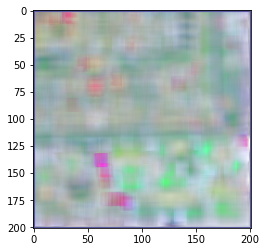

In [13]:
nr,nc,nb = glcmasi.shape #all bands
X = glcmasi.reshape((nr*nc, nb))

# nr,nc,nb = img[:,:,[1,2,3,7]].shape # 10m bands
# X = img[:,:,[1,2,3,7]].reshape((nr*nc, nb))

X.shape
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

from sklearn import decomposition
pca = decomposition.PCA(n_components=4)
pca.fit(X_std)
X_pca = pca.transform(X_std)
X_pca.shape

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_pca)

img_pca = X_pca.reshape((nr,nc,4))
print(img_pca.shape)

#Pseudocolor image extracted through PCA analysis
plt.imshow(MyNormalize(img_pca,1))

In [14]:
print(X_pca.components_)

AttributeError: 'numpy.ndarray' object has no attribute 'components_'

In [ ]:
x, y, z = img_pca.shape
d1 = img_pca[:,:,0]
d2 = img_pca[:,:,1]
d3 = img_pca[:,:,2]
d4 = img_pca[:,:,3] 

plt.scatter([d1], [d2], [d3], [d4], c=z)
plt.show()

In [ ]:
# Remove PC1
Xmean = img_pca - img_pca.mean(axis=0)
value = Xmean @ pca.components_[0]
pc1 = value.reshape(-1,1) @ pca.components_[0].reshape(1,-1)
Xremove = X_pca - pc1
plt.scatter(Xremove[:,0], Xremove[:,1], c=y)
plt.show()

In [ ]:
from sklearn.datasets import load_iris
irisdata = load_iris()

In [ ]:
for key in irisdata:
    print(key)

In [ ]:
array = irisdata.get('data')
print(array.shape)